# Tutorial 10 - B cell lymphoma (CosMx + CODEX)

In [1]:
import os
import torch
import scanpy as sc
import importlib
import numpy as np

In [2]:
from COSIE.data_preprocessing import load_data
from COSIE.utils import setup_seed
from COSIE.configure import get_default_config
from COSIE.COSIE_framework import COSIE_model
from COSIE.downstream_analysis import *

config = get_default_config()
setup_seed(config['training']['seed'])


## Load data

In [3]:
file_path = '../../../project/SpatialMultimodal/datasets/B_cell_lymphoma'

In [4]:
adata1_codex = sc.read_h5ad(os.path.join(file_path, 'No12', 'No12_codex_v2_HistoSweep.h5ad'))
adata1_rna  = sc.read_h5ad(os.path.join(file_path, 'No12', 'No12_cosmx_v2_HistoSweep.h5ad'))
adata2_codex = sc.read_h5ad(os.path.join(file_path, 'No5', 'No5_codex_v2_HistoSweep.h5ad'))
adata2_rna  = sc.read_h5ad(os.path.join(file_path, 'No5', 'No5_cosmx_v2_HistoSweep.h5ad'))

In [8]:
adata1_codex.var_names_make_unique()
adata2_codex.var_names_make_unique()

In [10]:
adata1_he = sc.AnnData(X=adata1_codex.obsm['UNI_feature'])
adata2_he = sc.AnnData(X=adata1_rna.obsm['UNI_feature'])
adata3_he = sc.AnnData(X=adata2_codex.obsm['UNI_feature'])

adata1_he.obsm['spatial'] = adata1_codex.obsm['spatial'].copy()
adata2_he.obsm['spatial'] = adata1_rna.obsm['spatial'].copy()
adata3_he.obsm['spatial'] = adata2_codex.obsm['spatial'].copy()

adata1_he, adata2_he, adata3_he

(AnnData object with n_obs × n_vars = 29495 × 2048
     obsm: 'spatial',
 AnnData object with n_obs × n_vars = 11090 × 2048
     obsm: 'spatial',
 AnnData object with n_obs × n_vars = 28698 × 2048
     obsm: 'spatial')

## Define the dictionary structure for input data

In [11]:
data_dict = {
        'RNA': [None, adata1_rna, None],
        'HE': [adata1_he, adata2_he, adata3_he],
        'Protein': [None, None, adata2_codex]}

In [12]:
feature_dict, spatial_loc_dict, data_dict_processed = load_data(data_dict, n_comps=50)

-------- Processing shared modality HE across sections --------
Running Harmony for HE


2025-06-04 15:23:33,143 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2025-06-04 15:23:39,144 - harmonypy - INFO - sklearn.KMeans initialization complete.
2025-06-04 15:23:39,851 - harmonypy - INFO - Iteration 1 of 10
2025-06-04 15:24:06,875 - harmonypy - INFO - Iteration 2 of 10
2025-06-04 15:24:33,543 - harmonypy - INFO - Converged after 2 iterations


-------- Processing unique modality RNA for section 2 --------
-------- Processing unique modality Protein for section 3 --------
Extracting spatial location for section 1
Extracting spatial location for section 2
Extracting spatial location for section 3


## Specify the linkage indicator

In [18]:

Linkage_indicator = {
    ('s1', 's2'): [('HE', 'HE')],
    ('s1', 's3'): [('HE', 'HE')],
    ('s2', 's3'): [('HE', 'HE'),('RNA', 'Protein')],
}


## Define COSIE model and perform integration 

In [19]:
model = COSIE_model(config, feature_dict)
optimizer = torch.optim.Adam(model.parameters(), lr=config['training']['lr'])
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

All modalities: ['HE', 'RNA', 'Protein']
-------- Encoder description --------
Encoder [HE]: Input 50 → Hidden [256, 128]
Encoder [RNA]: Input 50 → Hidden [256, 128]
Encoder [Protein]: Input 50 → Hidden [256, 128]
-------- Dual prediction module description --------
Predictor [HE → RNA]: [128, 512, 512, 128]
Predictor [RNA → HE]: [128, 512, 512, 128]
Predictor [HE → Protein]: [128, 512, 512, 128]
Predictor [Protein → HE]: [128, 512, 512, 128]
Using device: cuda:0


In [20]:
final_embeddings = model.train_model(file_path, config, optimizer, device, feature_dict, spatial_loc_dict, 
                                     data_dict_processed, Linkage_indicator)

-------- Running Full-graph training mode --------
Computing linkage between HE (s1) and HE (s2)
Computing linkage between HE (s1) and HE (s3)
Computing linkage between HE (s2) and HE (s3)
Computing linkage between RNA (s2) and Protein (s3)
Selecting 3000 HVGs for RNA with 6199 genes for linkage construction
Number of overlapping features: 14
Converting adata1_tmp.X from sparse to dense...
Model moved to cuda:0!
-------- Construction of input graphs --------
-------- Constructing spatial graph for s1 --------
Constructing feature graph for [s1 - HE]...
-------- Constructing spatial graph for s2 --------
Constructing feature graph for [s2 - HE]...
Constructing feature graph for [s2 - RNA]...
-------- Constructing spatial graph for s3 --------
Constructing feature graph for [s3 - HE]...
Constructing feature graph for [s3 - Protein]...
Training started!


Training Epochs: 100%|████████████████████████████████████████████████████████████████| 600/600 [02:31<00:00,  3.96it/s]


Running Evaluation...
Missing modality [RNA] in Section [s1]
Using predictor [HE → RNA] to recover missing embedding...
Missing modality [Protein] in Section [s1]
Using predictor [HE → Protein] to recover missing embedding...
Missing modality [Protein] in Section [s2]
Using predictor [HE → Protein] to recover missing embedding...
Missing modality [RNA] in Section [s3]
Using predictor [HE → RNA] to recover missing embedding...
All embeddings have been saved to ../../../project/SpatialMultimodal/datasets/B_cell_lymphoma


## Perform clustering and visualization

Perform joint clustering...


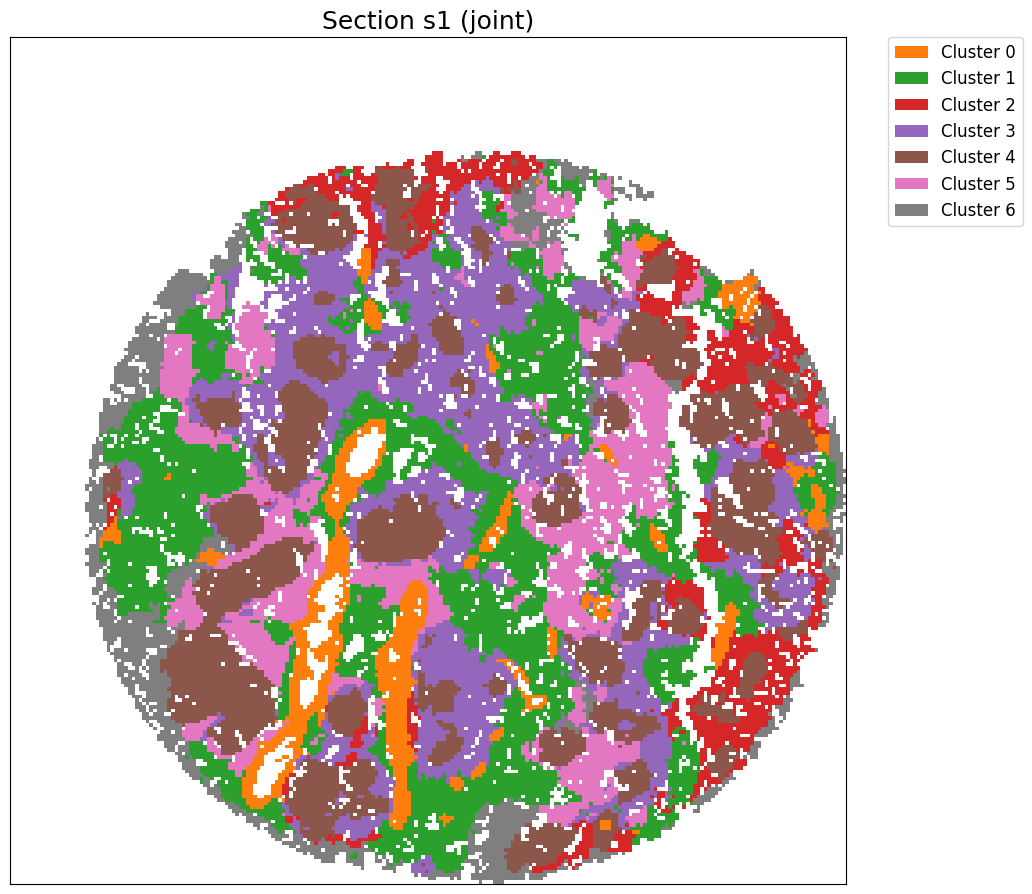

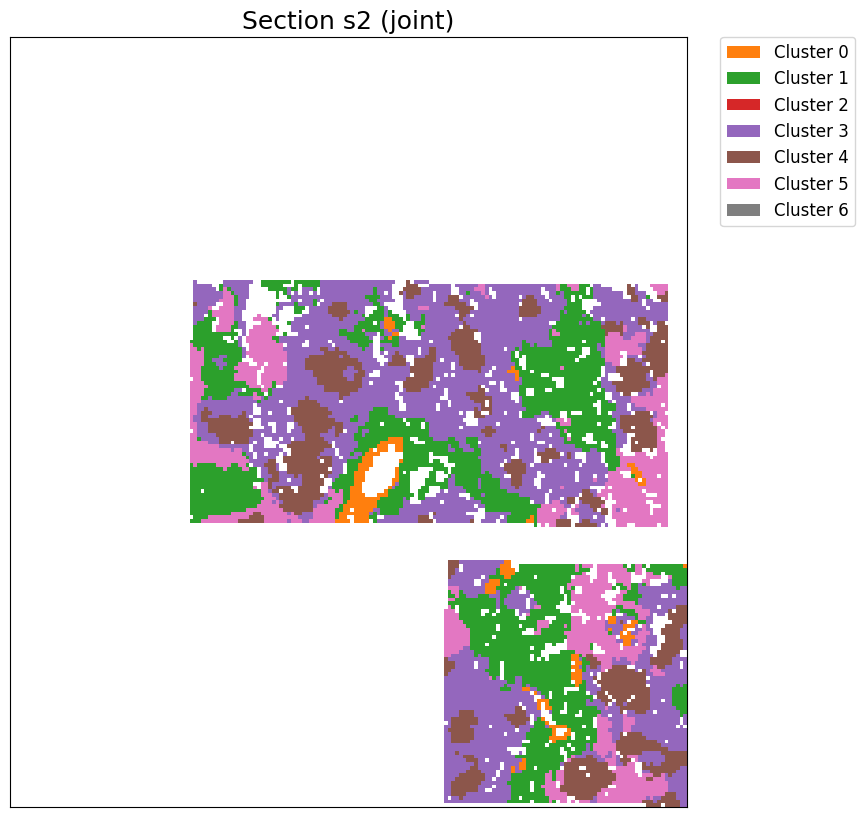

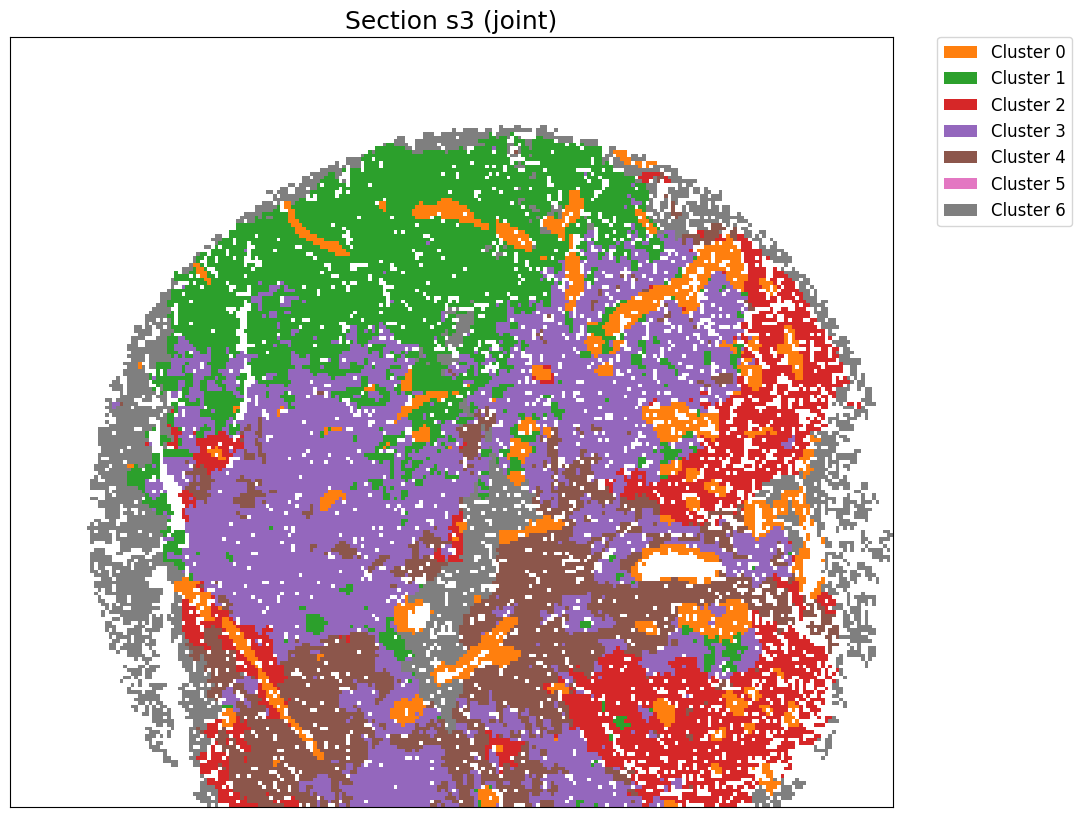

In [24]:
cluster_label = cluster_and_visualize_superpixel(final_embeddings, 
                                                 data_dict,
                                                 n_clusters=7,
                                                 mode="joint", 
                                                 vis_basis="spatial",  
                                                 # offset = True,
                                                 # colormap = 'tab10', 
                                                 # swap_xy=True, 
                                                 # invert_y=True,
                                                 figscale = 20)

## Imputation for section1: RNA+protein

##### RNA

In [40]:
adata1_RNA_imputed = perform_imputation(data_dict,
    final_embeddings,
    target_section = 's1',
    target_modality = 'RNA',
    K_num=50,
    target_molecules='All',
    )

Using modality [HE] in section [s1] as spatial/obs reference
[RNA] exists in ['s2'], which will be used as source data section


In [45]:
adata1_RNA_imputed_norm = create_normalized_adata(adata1_RNA_imputed)
adata1_rna_norm = create_normalized_adata(adata1_rna)

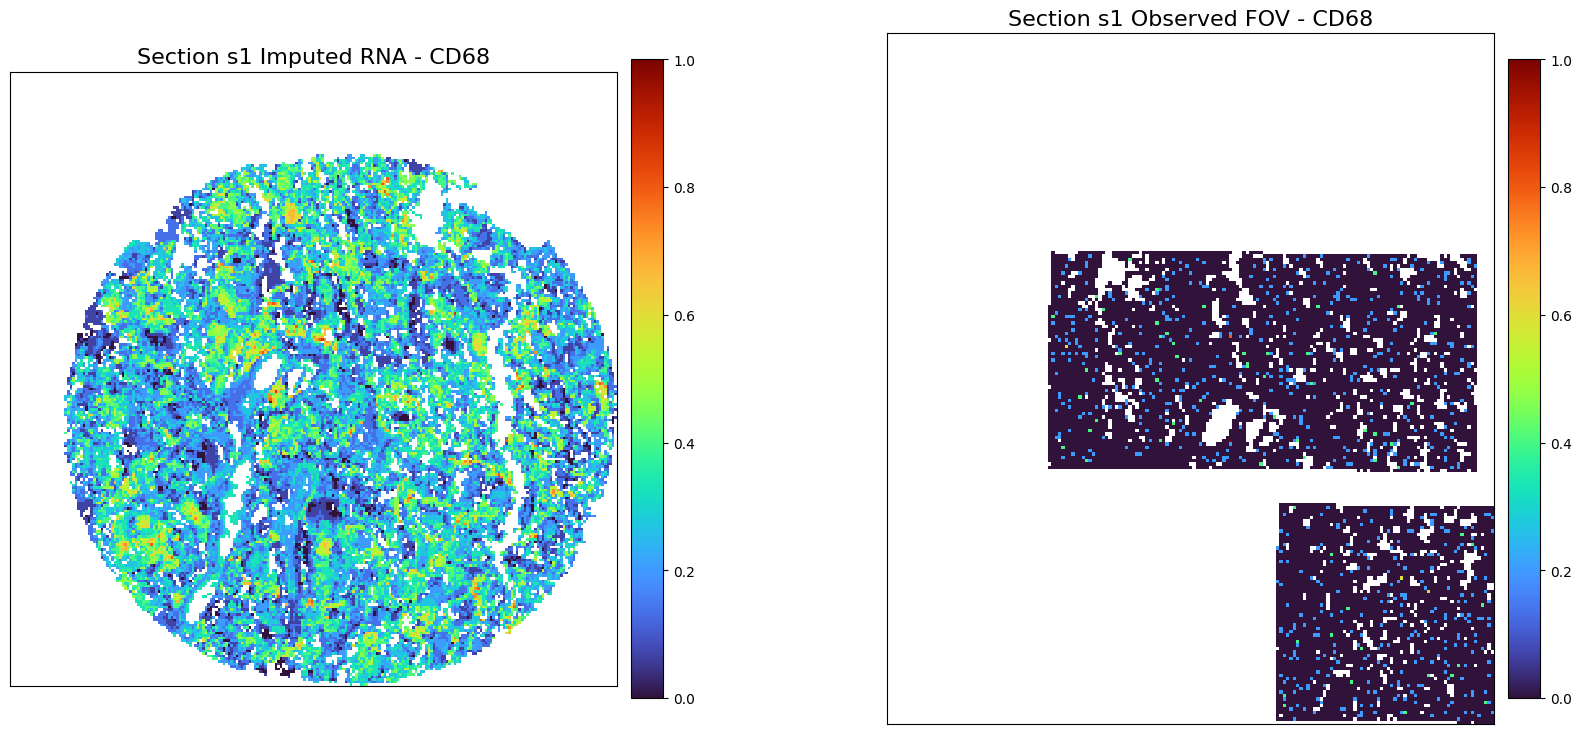

In [89]:
plot_marker_comparison_superpixel('CD68',
                       adata1_RNA_imputed_norm, 
                       adata1_rna_norm, 
                       'Section s1 Imputed RNA', 
                       'Section s1 Observed FOV',
                        colormap = 'turbo',
                        figscale = 20,)

##### Protein

In [29]:
adata1_protein_imputed = perform_imputation(data_dict,
    final_embeddings,
    target_section = 's1',
    target_modality = 'Protein',
    K_num=50,
    target_molecules='All',
    )

Using modality [HE] in section [s1] as spatial/obs reference
[Protein] exists in ['s3'], which will be used as source data section


In [41]:
adata1_protein_imputed_norm = create_normalized_adata(adata1_protein_imputed)
adata2_codex_norm = create_normalized_adata(adata2_codex)

In [42]:
adata1_codex_norm = create_normalized_adata(adata1_codex)

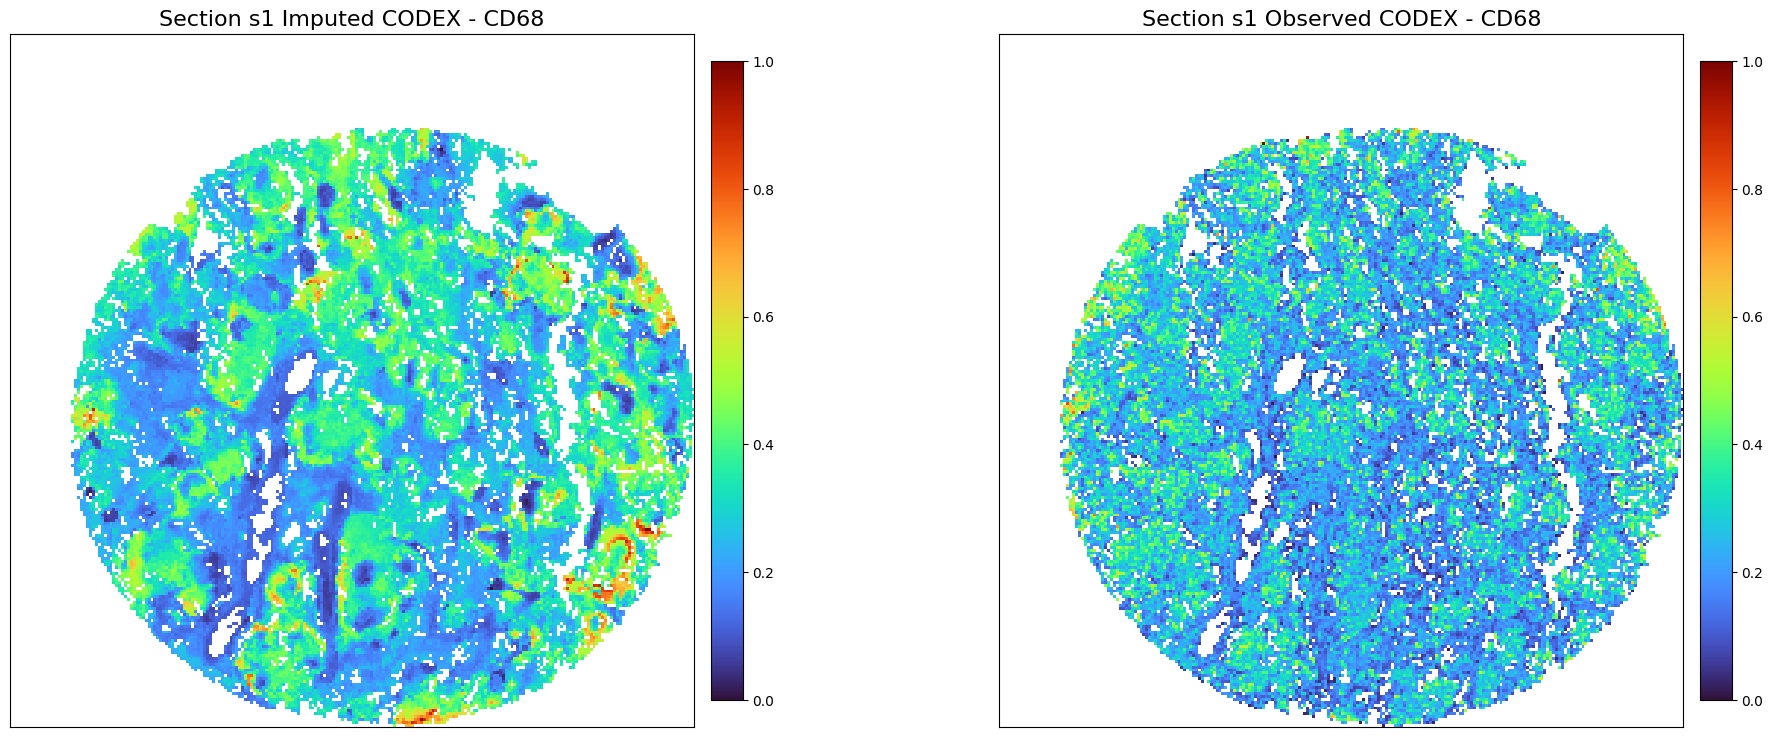

In [88]:
plot_marker_comparison_superpixel(
                       'CD68',
                       adata1_protein_imputed_norm, 
                       adata1_codex_norm, 
                       'Section s1 Imputed CODEX', 
                       'Section s1 Observed CODEX',
                        colormap = 'turbo',
                        figscale = 20,)

## Imputation for Section3: RNA

In [47]:
adata3_RNA_imputed = perform_imputation(data_dict,
    final_embeddings,
    target_section = 's3',
    target_modality = 'RNA',
    K_num=50,
    target_molecules='All',
    )

Using modality [HE] in section [s3] as spatial/obs reference
[RNA] exists in ['s2'], which will be used as source data section


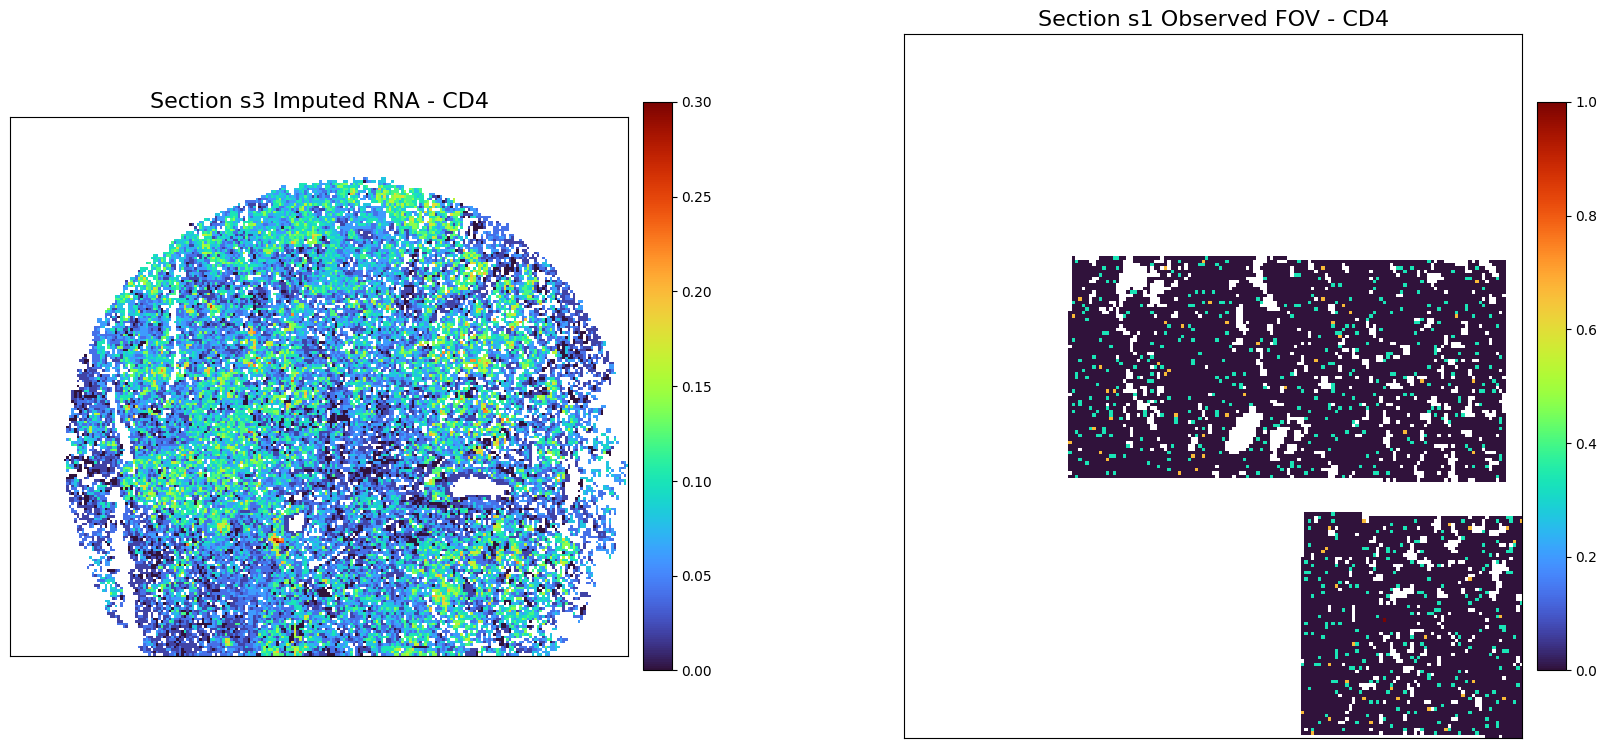

In [50]:
plot_marker_comparison_superpixel('CD4',
                       adata3_RNA_imputed, 
                       adata1_rna_norm, 
                       'Section s3 Imputed RNA', 
                       'Section s1 Observed FOV',
                        colormap = 'turbo',
                        figscale = 20,)